In [3]:
import tqdm
import pandas as pd 
import numpy as np 
import os
from itertools import chain
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU') 
        print(gpus[0].name)
    except RuntimeError as e:
        print(e)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
img_labels_df = pd.read_csv('data/image_labels.csv')

img_labels_df.head()

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,original_y_spacing
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [9]:
all_diagnoses = list(set(chain(*img_labels_df['diagnosis'].map(lambda x: x.split('|')).tolist())))
for diagnosis in all_diagnoses:
    img_labels_df[diagnosis] = img_labels_df['diagnosis'].map(lambda diagnoses: diagnosis in diagnoses)

diagnosis_counts = {diagnosis: img_labels_df[diagnosis].sum() for diagnosis in all_diagnoses}

print(f"Dataframe Shape: {img_labels_df.shape}")
img_labels_df.head(10)

Dataframe Shape: (112120, 26)


,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Emphysema,Mass,Infiltration,Fibrosis,Pneumothorax,Nodule,Cardiomegaly,Edema,Consolidation,Effusion
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,False,False,False,False,False,False,True,False,False,False
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,True,False,False,False,False,False,True,False,False,False
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,False,False,False,False,False,False,True,False,False,True
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,False,False,False,False,False,False,False,False,False,False
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,...,False,False,False,False,False,False,False,False,False,False
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,...,False,False,True,False,False,False,False,False,False,False
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,False,False


In [10]:
img_labels_df['vectorized_diagnoses'] = img_labels_df.apply(lambda x: [x[all_diagnoses].values], 1).map(lambda x: [float(val) for val in x[0]])
img_labels_df["img_path"] = img_labels_df['img_name'].apply(lambda x: "./data/images/" + x)
img_labels_df['split_diagnoses'] = img_labels_df.apply(lambda x: x['diagnosis'].split('|'), axis=1)

In [11]:
split: list[pd.DataFrame] = train_test_split(img_labels_df, test_size=0.15, random_state=2003)
training_df, validation_df = split
print(f"Training Size: {len(training_df)}\nValidation Size: {len(validation_df)}")

Training Size: 95302
Validation Size: 16818


In [12]:
training_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Fibrosis,Pneumothorax,Nodule,Cardiomegaly,Edema,Consolidation,Effusion,vectorized_diagnoses,img_path,split_diagnoses
97157,00025628_011.png,Effusion,12,25628,76,F,AP,3056,2544,0.139,...,False,False,False,False,False,False,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00025628_011.png,[Effusion]
59001,00014607_001.png,No Finding,1,14607,59,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00014607_001.png,[No Finding]
60617,00014958_003.png,Atelectasis|Effusion,2,14958,18,F,PA,2392,2082,0.143,...,False,False,False,False,False,False,True,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00014958_003.png,"[Atelectasis, Effusion]"
70223,00017298_000.png,No Finding,0,17298,58,F,PA,2766,2991,0.143,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00017298_000.png,[No Finding]
58344,00014427_019.png,Effusion|Infiltration,10,14427,51,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./data/images/00014427_019.png,"[Effusion, Infiltration]"
66049,00016318_002.png,Atelectasis|Infiltration|Nodule|Pneumothorax,2,16318,32,M,PA,2992,2991,0.143,...,False,True,True,False,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./data/images/00016318_002.png,"[Atelectasis, Infiltration, Nodule, Pneumothorax]"
60198,00014862_000.png,No Finding,0,14862,33,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00014862_000.png,[No Finding]
71779,00017691_019.png,Consolidation|Effusion|Infiltration,10,17691,61,M,AP,2500,2048,0.168,...,False,False,False,False,False,True,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./data/images/00017691_019.png,"[Consolidation, Effusion, Infiltration]"
1222,00000311_000.png,Fibrosis,0,311,46,M,PA,2500,2048,0.171,...,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",./data/images/00000311_000.png,[Fibrosis]
73039,00017991_010.png,Fibrosis|Infiltration,9,17991,64,M,PA,2678,2855,0.143,...,True,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",./data/images/00017991_010.png,"[Fibrosis, Infiltration]"


In [13]:
validation_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Fibrosis,Pneumothorax,Nodule,Cardiomegaly,Edema,Consolidation,Effusion,vectorized_diagnoses,img_path,split_diagnoses
50863,00012864_003.png,No Finding,3,12864,48,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00012864_003.png,[No Finding]
8978,00002358_003.png,No Finding,3,2358,40,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00002358_003.png,[No Finding]
4570,00001243_000.png,No Finding,0,1243,16,M,PA,2048,2500,0.168,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00001243_000.png,[No Finding]
10858,00002817_003.png,No Finding,12,2817,74,F,PA,2544,3056,0.139,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00002817_003.png,[No Finding]
38384,00010032_013.png,No Finding,13,10032,66,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00010032_013.png,[No Finding]
22541,00005975_002.png,No Finding,0,5975,9,F,PA,2422,1797,0.143,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00005975_002.png,[No Finding]
92317,00023068_011.png,Effusion|Infiltration|Nodule,10,23068,72,F,AP,3056,2544,0.139,...,False,False,True,False,False,False,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./data/images/00023068_011.png,"[Effusion, Infiltration, Nodule]"
93639,00023531_000.png,No Finding,0,23531,30,F,PA,2048,2500,0.168,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00023531_000.png,[No Finding]
59688,00014731_022.png,Emphysema|Nodule,23,14731,54,M,PA,2500,2048,0.168,...,False,False,True,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",./data/images/00014731_022.png,"[Emphysema, Nodule]"
13530,00003520_001.png,No Finding,1,3520,82,M,PA,2694,2837,0.143,...,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00003520_001.png,[No Finding]


In [14]:
idg_parameterized = ImageDataGenerator(height_shift_range= 0.07,
                                  width_shift_range=0.12,
                                  rotation_range=5,
                                  zoom_range=0.17,
                                  shear_range = 0.12,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  samplewise_center=True, 
                                  samplewise_std_normalization=True, 
                                  fill_mode = 'reflect',
                                )
img_dimensions = (128, 128)

In [15]:
training_gen = idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = "img_path",
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 32)

Found 95302 validated image filenames belonging to 15 classes.


In [16]:
validation_gen = idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                            directory=None,
                            x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                            class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                            color_mode = 'grayscale',
                            batch_size = 256)

Found 16818 validated image filenames belonging to 15 classes.


In [17]:
t_X, t_Y = next(idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 1024))

Found 95302 validated image filenames belonging to 15 classes.


In [18]:
v_X, v_Y = next(idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 1024))

Found 16818 validated image filenames belonging to 15 classes.


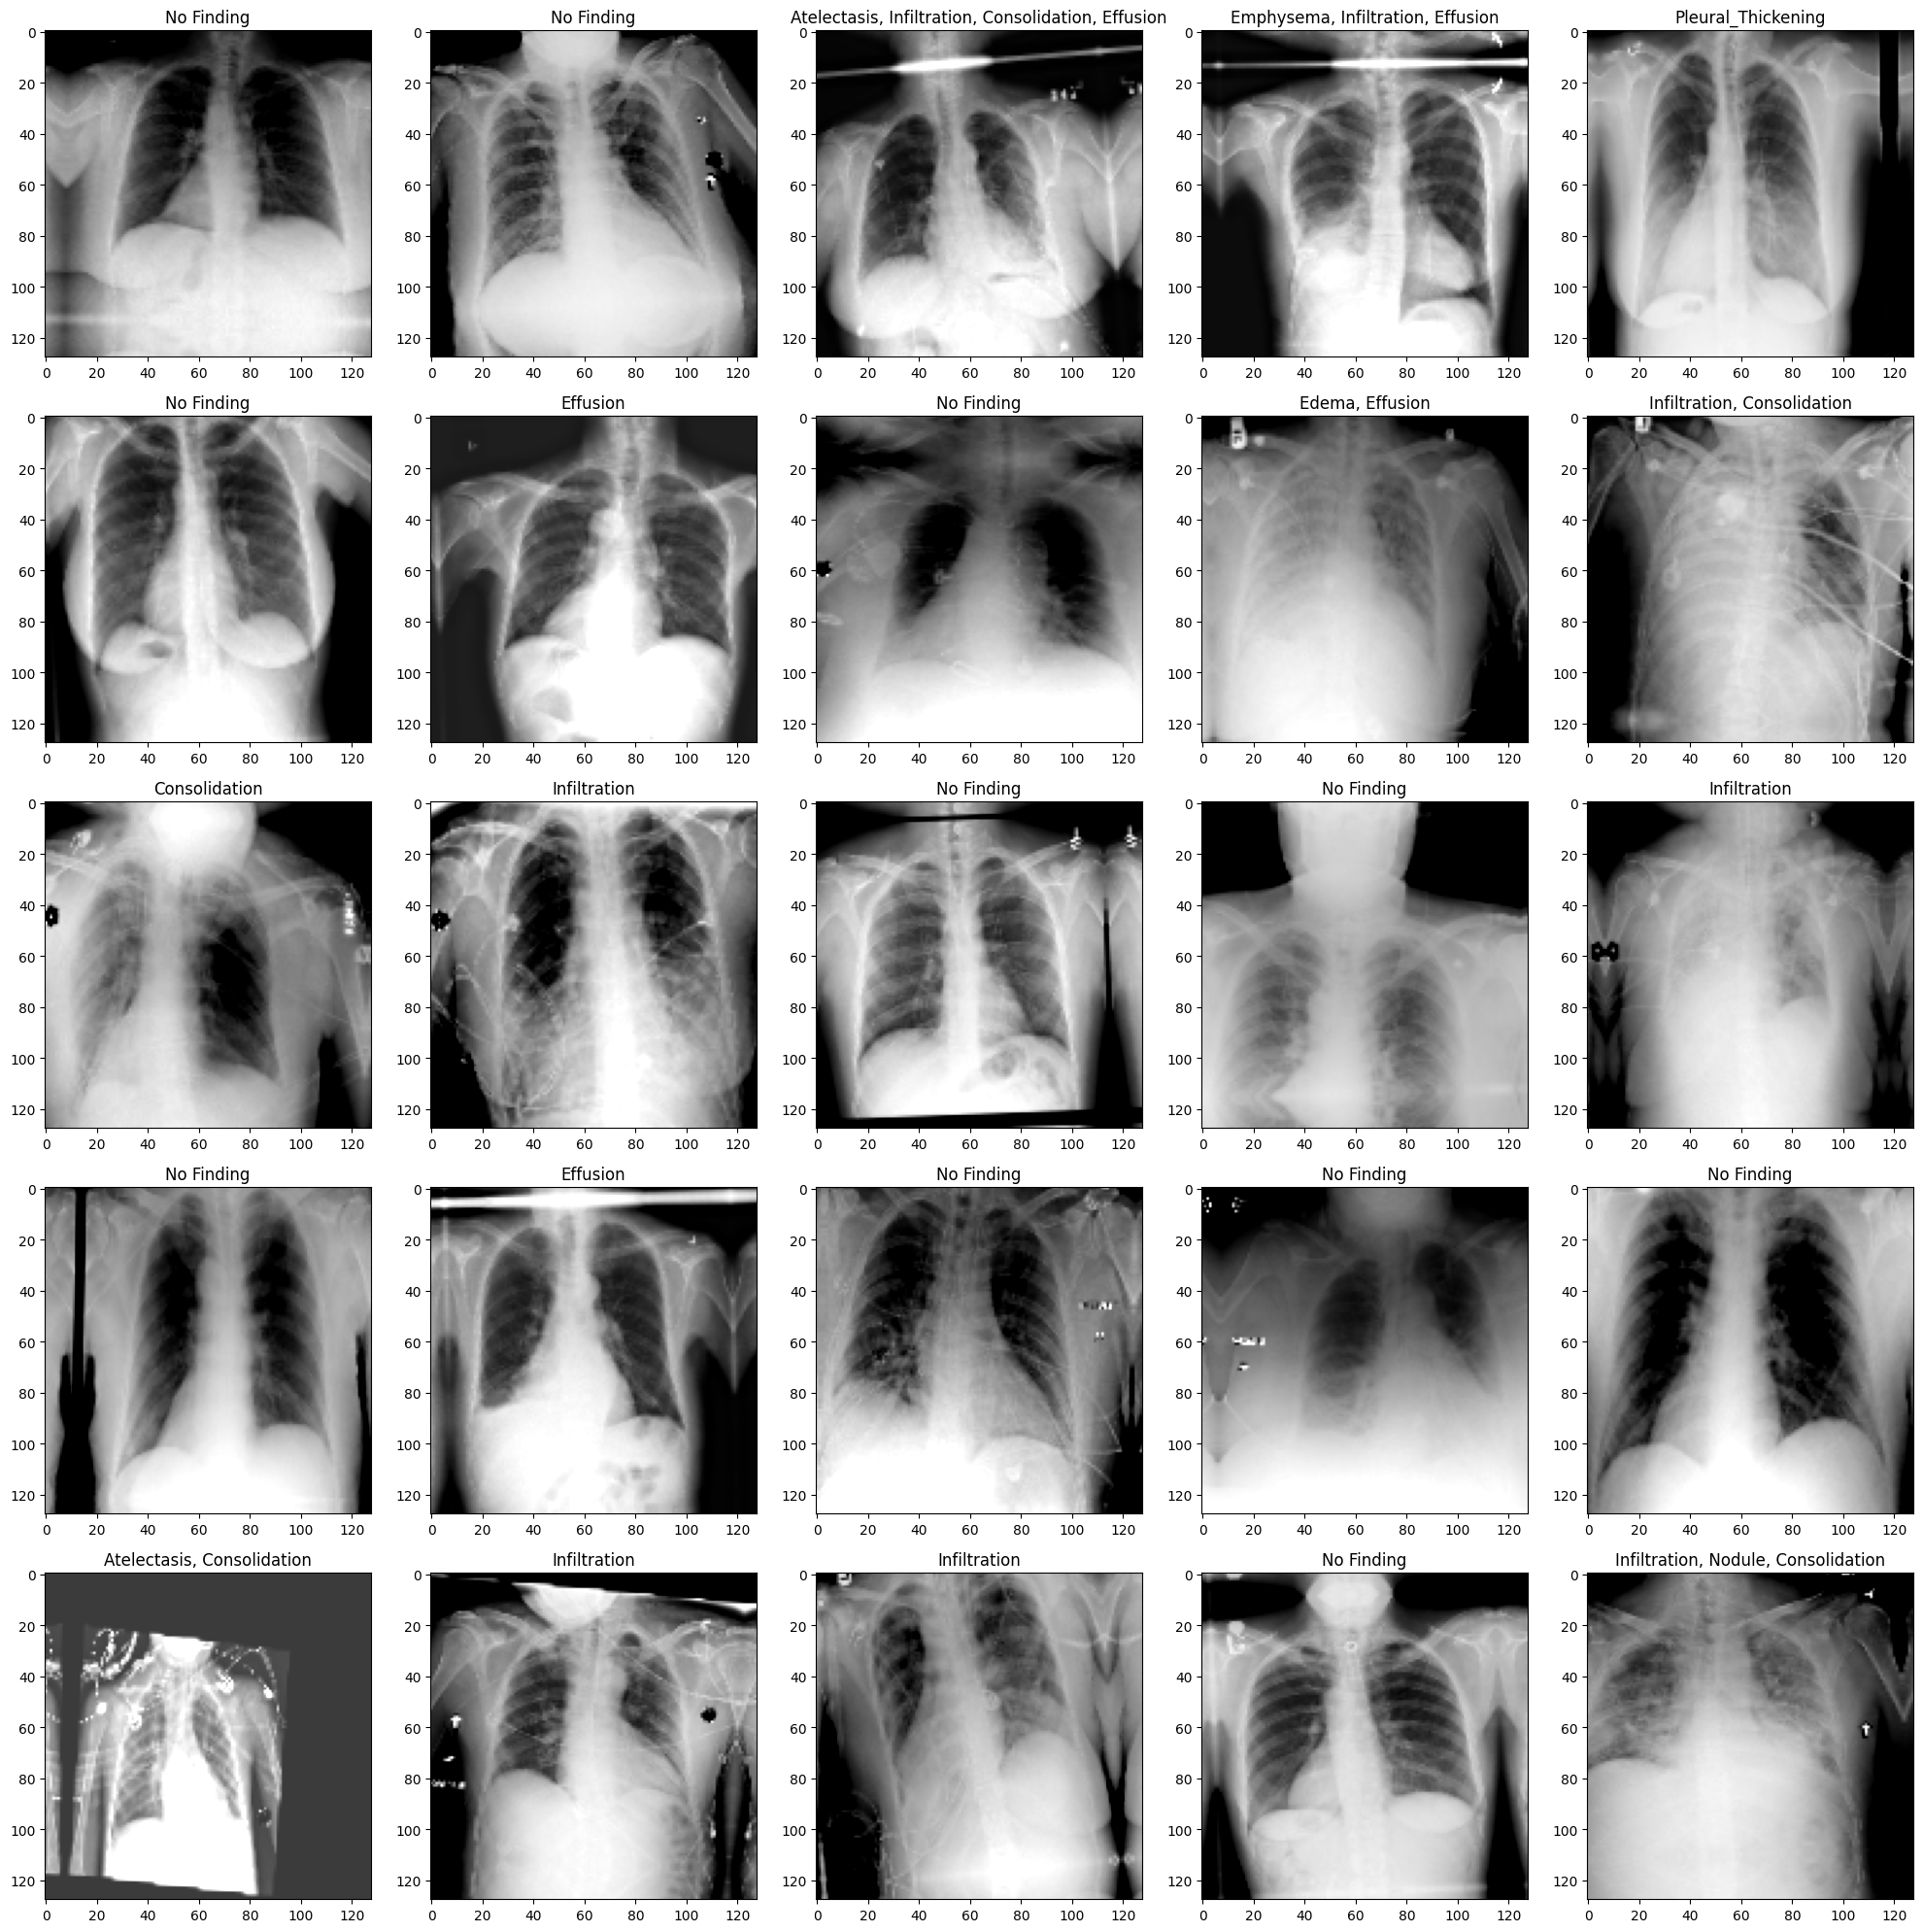

In [19]:
grid_size = 5

tr_x, tr_y = next(training_gen)

fig, matrix_axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))
for (img, labels, ax) in zip(tr_x, tr_y, matrix_axs.flatten()):
    ax.imshow(img[:, :, 0], cmap='gist_gray', vmin=-1.5, vmax=1.5)
    title = ', '.join([diagnosis for diagnosis, score in zip(all_diagnoses, labels) if score > 0.5])
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [32]:
mnet_model = MobileNet(input_shape = tr_x.shape[1:], 
                                 include_top = False, weights = None)

MULTI_DIAGNOSIS_MODEL_PARAMETERS = {
    "DROPOUT": 0.5,
    "DENSE": 512,
    "ACTIVATION": 'softmax',
    "OPTIMIZER": 'adam',
    "LOSS": 'categorical_crossentropy',
    "METRICS": ['accuracy']
}

In [33]:
multi_disease_model = Sequential()
multi_disease_model.add(mnet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(MULTI_DIAGNOSIS_MODEL_PARAMETERS["DROPOUT"]))
multi_disease_model.add(Dense(MULTI_DIAGNOSIS_MODEL_PARAMETERS["DENSE"]))
multi_disease_model.add(Dropout(MULTI_DIAGNOSIS_MODEL_PARAMETERS["DROPOUT"]))
multi_disease_model.add(Dense(len(all_diagnoses), activation = MULTI_DIAGNOSIS_MODEL_PARAMETERS["ACTIVATION"]))
multi_disease_model.compile(optimizer = MULTI_DIAGNOSIS_MODEL_PARAMETERS["OPTIMIZER"], loss = MULTI_DIAGNOSIS_MODEL_PARAMETERS["LOSS"],
                           metrics = MULTI_DIAGNOSIS_MODEL_PARAMETERS["METRICS"])
multi_disease_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 15)               

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

NUM_EPOCHS=1

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_multi_disease_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Training
history = multi_disease_model.fit(
    training_gen,
    validation_data=validation_gen,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

2979/2979 [==============================] - 3280s 1s/step - loss: 6467.4194 - accuracy: 0.3417 - val_loss: 14387.3252 - val_accuracy: 0.5407


In [37]:
test_loss, test_acc = multi_disease_model.evaluate(v_X, v_Y, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

32/32 - 4s - loss: 17893.0098 - accuracy: 0.5420 - 4s/epoch - 139ms/step
Test accuracy: 0.5419921875, Test loss: 17893.009765625


In [38]:
# Assuming X_test is your test set
predictions = multi_disease_model.predict(v_X)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(v_Y, axis=1)

32/32 [==============================] - 6s 162ms/step


In [39]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=all_diagnoses))

# Generate and display confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

                    precision    recall  f1-score   support

         Pneumonia       0.00      0.00      0.00        13
Pleural_Thickening       0.00      0.00      0.00        29
        No Finding       0.54      1.00      0.70       555
       Atelectasis       0.00      0.00      0.00       111
            Hernia       0.00      0.00      0.00         2
         Emphysema       0.00      0.00      0.00        18
              Mass       0.00      0.00      0.00        45
      Infiltration       0.00      0.00      0.00       121
          Fibrosis       0.00      0.00      0.00         6
      Pneumothorax       0.00      0.00      0.00        17
            Nodule       0.00      0.00      0.00        29
      Cardiomegaly       0.00      0.00      0.00        18
             Edema       0.00      0.00      0.00         7
     Consolidation       0.00      0.00      0.00        20
          Effusion       0.00      0.00      0.00        33

          accuracy                    

c:\Users\cgarcia0\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cgarcia0\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cgarcia0\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
multi_disease_model.save('multi_disease_model.h5')
